# The L2 Ball's View of the L1 Ball

John Mount<br/>
jmount@win-vector.com<br/>
Win Vector LLC<br/>
6-15-2023<br/>

## Abstract


Define $a_{n}$ to be expected value of $\sum_{i=1}^{n} |x_i|$ given $\sum_{i=1}^{n} x_i^2 = 1$ where $x$ is uniformly distributed such. Define $v_{n}$ as the variance of this same sum.

That is: for $x \in \mathbb{R}^{n}$ distributed uniformly on the boundary of the unit ball, what is the expected L1 norm of $x$ (and its variance)?

The answer is, for large $n$: $a_n \approx \sqrt{2 n/ \pi}$ and $v_{n} \approx 1 - 3 / \pi$ (a constant, independent of dimension!).

A cool application of the above is the following. Generate two vectors $v_1, v_2 \in \mathbb{R}^{n}$ with each coordinate independent mean zero variance one normal. This is a standard way to generate sperically symmetric distributed vectors, and is the $n$-dimensional normal or Gaussian. Consider how often the L1 and L2 metrics agree on which of $v_1$ or $v_2$ is larger; call this the "L1L2 AUC or concordance" (as it is that kind of order agreement statistic). The limit (as $n \rightarrow \infty$) of the L1L2 AUC is $\kappa(1, \sqrt{\pi - 3}) \approx 0.885$. Where $\kappa(\sigma_1, \sigma_2)$ defined as $\text{P}[(X + Y \ge 0) = (X \ge 0)]$ where $X$ is normal mean $0$ variance $\sigma_1^2$ and $Y$ is independent normal mean $0$ variance $\sigma_2^2$.

## Deriving the Solution

Let's work up to the answer. We will confirm intermediate claims in Python.


In [1]:
import sympy
from sympy import cos, exp, factorial, gamma, loggamma, pi, sin, sqrt
from IPython.display import display
import numpy.random
import numpy as np
import pandas as pd

sympy.init_printing(use_unicode=False, wrap_line=False)


In [2]:
rng = numpy.random.default_rng(seed=12345678903141592653589793)


### Solving for $a_{n}$

By the linearity of expectation we have $\text{E}[\sum_{i=1}^{n-1} |x_i|] = n \text{E}[|x_1|]$.

We have the constraint $\sum_{i=1}^{n-1} x_i^2 = 1 - x_n^2$. So if $x_n = \cos(z)$ then $\sum_{i=1}^{n-1} x_i^2 = \sin(z)^2$.  

We can work out that: $a_{1} = 1$.  For $n \ge 2$ we have $a_{n}$ is $n$ times the expected value of $x_{n}$. This is:

$$
a_{n} = n 
 \frac{
    \int_{\lambda = 0}^{1} \cos((\pi/2) \lambda) \sin((\pi/2) \lambda)^{n-2} \text{d}\lambda}{
    \int_{\lambda = 0}^{1} \sin((\pi/2) \lambda)^{n-2} \text{d}\lambda
 }
$$

The $\sin((\pi/2) \lambda)^{n-2}$ term being the density of the $n-1$ sphere volume in each portion of the integral.


In [3]:
# define a_1 and a_2
a_1 = 1
x = sympy.Symbol('x')
a_2 = 2 * sympy.integrate(cos((pi/2) * x), (x, 0, 1)) / sympy.integrate(1, (x, 0, 1))
a_2


In [4]:
float(a_2)


We can confirm the values of $a_1$ and $a_2$ empirically.


In [5]:
def l1_example(dim: int):
    """Compute l1-norm of a uniformly selected unit l2-vector"""
    dim = int(dim)
    assert dim >= 1
    # generate a uniform L2-norm 1 vector
    v = None
    v_norm_sq = 0
    while v_norm_sq <= 0:
        v = rng.normal(size=dim)
        v_norm_sq = np.dot(v, v)
    v = v / np.sqrt(v_norm_sq)
    # return the L1 norm of this vector
    return np.sum(np.abs(v))


In [6]:
# get average l1 metric of many unit l2-examples in dimension 1
a_1_empirical = np.mean([l1_example(1) for r in range(100000)])

a_1_empirical


In [7]:
def relative_abs_error(*, target, estimate):
    assert target > 0
    return np.abs(target - estimate) / np.abs(target)


In [8]:
assert relative_abs_error(target=a_1, estimate=a_1_empirical) < 1e-2


In [9]:
# get average l1 metric of many unit l2-examples in dimension 2
a_2_empirical = np.mean([l1_example(2) for r in range(100000)])

a_2_empirical


In [10]:
assert relative_abs_error(target=a_2, estimate=a_2_empirical) < 1e-2


Integration by parts would let us derive the following two identities for non-negative integer $k$.

$$
s(k) 
 := \int_{\lambda = 0}^{1} \sin((\pi/2) \lambda)^{k} \text{d}\lambda 
 = \frac{\Gamma(k/2 + 1/2)}{\Gamma(k/2 + 1) \sqrt{\pi}}
$$

$$
c(k) 
 := \int_{\lambda = 0}^{1} \cos((\pi/2) \lambda) \sin((\pi/2) \lambda)^{k} \text{d}\lambda 
 = \frac{2}{(k+1) \pi}
$$

We then have for $n \ge 2$:

$$
a_{n} = n c(n-2) / s(n-2)
$$


In [11]:
def s(k):
    """Compute s() integral for k >= 0"""
    return gamma((k+1) * sympy.Rational(1,2)) / (gamma((k+2) * sympy.Rational(1,2)) * sqrt(pi))

def c(k):
    """Compute c() integral for k >= 0"""
    return 2 / ((k + 1) * pi)


In [12]:
for k in range(5):
    s_k = s(k)
    i_k = sympy.integrate(sin((pi/2)*x)**k, (x, 0, 1))
    assert s_k == i_k
    print(f"s({k}): {(s_k, i_k)}")
  


s(0): (1, 1)
s(1): (2/pi, 2/pi)
s(2): (1/2, 1/2)
s(3): (4/(3*pi), 4/(3*pi))
s(4): (3/8, 3/8)


In [13]:
for k in range(5):
    c_k = c(k)
    i_k = sympy.integrate(sin((pi/2)*x)**k * cos((pi/2)*x), (x, 0, 1))
    assert c_k == i_k
    print(f"c({k}): {(c_k, i_k)}")


c(0): (2/pi, 2/pi)
c(1): (1/pi, 1/pi)
c(2): (2/(3*pi), 2/(3*pi))
c(3): (1/(2*pi), 1/(2*pi))
c(4): (2/(5*pi), 2/(5*pi))


In [14]:
def a_soln(n: int):
    """Compute a_{n} from a_{n-1} using recurrence formula"""
    n = int(n)
    assert n >= 1
    if n <= 1:
        return 1
    return n * c(n-2) / s(n-2)


In [15]:
assert a_soln(1) == a_1
assert a_soln(2) == a_2


In [16]:
a_3 = a_soln(3)

a_3


In [17]:
# get average l1 metric of many unit l2-examples in dimension 3
a_3_empirical = np.mean([l1_example(3) for r in range(100000)])

a_3_empirical


In [18]:
assert relative_abs_error(target=a_3, estimate=a_3_empirical) < 1e-2


And let's try that for $a_4$.


In [19]:
a_4 = a_soln(4)

a_4


In [20]:
float(a_4)


In [21]:
# get average l1 metric of many unit l2-examples in dimension 4
a_4_empirical = np.mean([l1_example(4) for r in range(100000)])

a_4_empirical


In [22]:
assert relative_abs_error(target=a_4, estimate=a_4_empirical) < 1e-2


Let's try a couple of larger $n$.


In [23]:
a_10 = a_soln(10)

a_10


In [24]:
float(a_10)


In [25]:
# get average l1 metric of many unit l2-examples in dimension 10
a_10_empirical = np.mean([l1_example(10) for r in range(100000)])

a_10_empirical


In [26]:
assert relative_abs_error(target=a_10, estimate=a_10_empirical) < 1e-2


In [27]:
a_11 = a_soln(11)

a_11


In [28]:
float(a_11)


In [29]:
# get average l1 metric of many unit l2-examples in dimension 11
a_11_empirical = np.mean([l1_example(11) for r in range(100000)])

a_11_empirical


In [30]:
assert relative_abs_error(target=a_11, estimate=a_11_empirical) < 1e-2


## The Limiting $a_{n}$


For non-negative $k$ define:

$$
z(k) = \frac{\Gamma(k/2 + 1/2)}{\Gamma(k/2 + 1)}
$$.

First $z(k)$ is decreasing, as using $x \Gamma(x) = \Gamma(x+1)$ we can show that $z(k) / z(k+1) = (k/2 + 1)/(k/2 + 1/2) \gt 1$.


Now consider:

$$
\begin{align*} 
\sqrt{z(k-1) z(k)}
 &= \sqrt{\frac{\Gamma(k/2)}{\Gamma(k/2 + 1/2)} \frac{\Gamma(k/2 + 1/2)}{\Gamma(k/2 + 1)}} \\
 &= \sqrt{\frac{\Gamma(k/2)}{\Gamma(k/2 + 1)}} \\
 &= \sqrt{2/k}
\end{align*} 
$$

As $z(k)$ is decreasing we have: $z(k-1) > \sqrt{2/k} > z(k)$. Which, by the generality of $k$, implies $\sqrt{2/k} > z(k) > \sqrt{2/(k+1)}$.

Let's reconfirm this numerically.


In [31]:
def z(n: int):
    """Simpler fn to stand in for s()"""
    n = int(n)
    assert n > 0
    return exp(loggamma(n/2 + 1/2) - loggamma(n/2 + 1))


In [32]:
z_10000 = z(10000)

z_10000


In [33]:
assert float(sqrt(2 / 10000)) > z_10000
assert z_10000 > float(sqrt(2 / (10000 + 1)))


When $n > 2$ we have:

$$ 
\sqrt{\frac{2}{(n + 1) \pi}} < s(n) < \sqrt{\frac{2}{n \pi}}
$$

$$
\begin{align*} 
c(n) &= \frac{2}{(n+1) \pi} \\
a_{n} &= n c(n-2) / s(n-2) 
\end{align*}
$$

So:

$$
n \frac{2}{(n-1) \pi} \sqrt{\frac{(n-2) \pi}{2}} < a_{n} < n\frac{2}{(n-1) \pi} \sqrt{\frac{(n-1) \pi}{2}} \\
\frac{n}{n-1} \sqrt{\frac{2 (n-2)}{\pi}} < a_{n} < \frac{n}{n-1} \sqrt{\frac{2 (n-1)}{\pi}} 
$$


Which is enough to establish the original claim $a_{n} \asymp \sqrt{\frac{2 n}{\pi}}$ for large $n$.


We can recheck that a large that $a_{n} / \sqrt{n}$ is near $\sqrt{2 / \pi}$ for large $n$.


In [34]:
# theoretical a_n / sqrt(n) limit
float(sqrt(2 / pi))


In [35]:
# a_1000 check
a_1000 = float(a_soln(1000))

a_1000 / 1000**(1/2)


In [36]:
assert float((1000 / (1000 - 1)) * sqrt(2 * (1000 - 2) / pi)) < a_1000
assert a_1000 < float((1000 / (1000 - 1)) * sqrt(2 * (1000 - 1) / pi))


In [37]:
# a_2000 check
a_2000 = float(a_soln(2000))

a_2000 / 2000**(1/2)


In [38]:
assert float((2000 / (2000 - 1)) * sqrt(2 * (2000 - 2) / pi)) < a_2000
assert a_2000 < float((2000 / (2000 - 1)) * sqrt(2 * (2000 - 1) / pi))


## The local behavior of $a_{n} / \sqrt{n}$

$s(n-2) / s(n)$ has a fairly simple form: $n/(n-1)$.


In [39]:
# s(n-2)/s(n) example
sn2n1_ratio = s(38) / s(40)

sn2n1_ratio


In [40]:
assert sn2n1_ratio == sympy.Rational(40, 39)


This means $(a_{n+2} / \sqrt{n+2}) / (a_{n} / \sqrt{n})$ should be manageable.

$$
(a_{n+2} / \sqrt{n+2}) / (a_{n} / \sqrt{n}) = \frac{\sqrt{n}}{\sqrt{n+2}} \frac{(n+2) c(n)}{n c(n-2)} \frac{s(n-2)}{s(n)}
$$


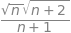

In [41]:
n = sympy.Symbol('n')

ratio = (sqrt(n) / sqrt(n+2)) * ( ((n+2)*c(n)) / (n*c(n-2)) ) * n/(n-1)
ratio


In [42]:
num, den = sympy.fraction(ratio**2)

den_num_diff = (den - num).expand()

den_num_diff


In [43]:
assert den_num_diff > 0


The denominator is larger than the numerator in our ratio squared. This means the sequence $a_{i + 2*j}$ is strictly decreasing as a sequence in $j$ ($i \in {0, 1}$, $j$ non-negative integer).


In [44]:
# check sequence decreasing when we jump by 2
assert float(a_4 / sqrt(4)) < float(a_2 / sqrt(2))
assert float(a_3 / sqrt(3)) < float(a_1 / sqrt(1))
# other non-step 2 checks
assert float(a_4 / sqrt(4)) < float(a_3 / sqrt(3))
assert float(a_3 / sqrt(3)) < float(a_2 / sqrt(2))
assert float(a_2 / sqrt(2)) < float(a_1 / sqrt(1))


$a_{n} / \sqrt{n}$ is likely a decreasing sequence overall. However our earlier bound isn't tight enough to easily demonstrate this.


## Estimating the Variance

Define $v_{n}$ as the variance of $\sum_{i=1}^{n} |x_i|$, where $x_i$ are picked uniformly such that $\sum_{i=1}^{n} x_i^2 = 1$.

By our above arguments and the linearity of expectation, $\text{E}[|x_{i}|]$ is $a_{n}/n = c(n-2)/s(n-2)$. So we have:

$$
\begin{align*}
\text{var}(|x_{i}|) &= \text{E}[(|x_{i}| - \text{E}[|x_{i}|])^2] \\
 &= \text{E}[(|x_{i}| - c(n-2)/s(n-2))^2] \\
 &= \text{E}[|x_{i}|^2] - 2 (c(n-2)/s(n-2)) \text{E}[|x_{i}|] + (c(n-2)/s(n-2))^2] \\
 &= \text{E}[|x_{i}|^2] - (c(n-2)/s(n-2))^2 \\
 &= \text{E}[x_{i}^2] - (c(n-2)/s(n-2))^2 \\
 &= 1/n - (c(n-2)/s(n-2))^2 
\end{align*}
$$

From earlier we know $(c(n-2)/s(n-2))^2 \asymp 2 / (n \pi)$. So $\text{var}(|x_{i}|) \asymp (1 - 2/\pi) / n$.

Let's check if our single coordinate estimates were correct.


In [45]:
def mean_and_var(x):
    """return mean and variance of vector entries"""
    return (np.mean(x), np.var(x))


In [46]:
def l1_example_first_coord(dim: int):
    """Compute l1-norm of a uniformly selected unit l2-vector"""
    dim = int(dim)
    assert dim >= 1
    # generate a uniform L2-norm 1 vector
    v = None
    v_norm_sq = 0
    while v_norm_sq <= 0:
        v = rng.normal(size=dim)
        v_norm_sq = np.dot(v, v)
    v = v / np.sqrt(v_norm_sq)
    # return absolute value of the first coordinate
    return np.abs(v[0])


In [47]:
# theoretical mean abs first coord and var abs first coord for dimension 1000
theoretical_mean_var_2 = (
    float(sqrt(2 / (1000 * pi))), 
    float((1 - 2/pi) / 1000)
    )

theoretical_mean_var_2


In [48]:
# empirical mean and var of absolute value of first coordinate for dimension 1000
empirical_mean_var_2 = mean_and_var(
    [l1_example_first_coord(1000) for r in range(100000)]
    )

empirical_mean_var_2


In [49]:
for i in range(2):
    assert relative_abs_error(
        target=theoretical_mean_var_2[i],
        estimate=empirical_mean_var_2[i]) < 1e-2


*If* the coordinates and variances were independent we would expect variance to then be additive and have $v_{n} = n \text{var}(|x_{i}|) \approx n (1 - 2/\pi) / n = 1 - 2/\pi$. This isn't they case. The general form for adding variances is: $\text{var}(\sum_i z_i) = \sum_i \text{var}(z_i) + 2 \sum_{i < j} \text{cov}(z_i, z_j)$.


Let's try and take a look at the general per-coordinate covariance term (by symmetry they all have the same expectations).


In [50]:
def l1_example_first_2_coord_cov(*, dim: int, reps: int = 100000):
    """Compute covariance of absolute values of first two coordinates"""
    dim = int(dim)
    reps = int(reps)
    assert dim >= 2
    assert reps > 0
    frames = []
    for rep in range(reps):
        # generate a uniform L2-norm 1 vector
        v = None
        v_norm_sq = 0
        while v_norm_sq <= 0:
            v = rng.normal(size=dim)
            v_norm_sq = np.dot(v, v)
        v = v / np.sqrt(v_norm_sq)
        # collect absolute value of the first two coordinates
        frames.append(pd.DataFrame({'x0': [np.abs(v[0])], 'x1': [np.abs(v[1])]}))
    d = pd.concat(frames, ignore_index=True)
    a = np.mean(d["x0"] * d["x1"])
    b = np.mean(d["x0"]) * np.mean(d["x1"])
    return  (a, b, a-b) 


The theoretic covariance is $\text{E}[|x| |y|] - \text{E}[|x|] \text{E}[|y|]$.
In $2 d$ the expected L1 norm is $4 / \pi$, so each coordinate has
expectation $2 / \pi$. $\text{E}[|x|] \text{E}[|y|]$ is exactly the integral $c(1) = 1/\pi$. This gives us the covariance in $2 d$ is $1 / \pi - ( 2 / \pi )^2$.


In [51]:
# The 2-d covariance is:
cov_2d_theory = (float(1/pi), float((2/pi)**2), float(1/pi - (2/pi)**2))

cov_2d_theory


In [52]:
# empirically estimate covariance for dimension 2
cov_2d_empirical = l1_example_first_2_coord_cov(dim=2)

cov_2d_empirical


In [53]:
for i in range(2):
    assert relative_abs_error(
        target=cov_2d_theory[i],
        estimate=cov_2d_empirical[i]) < 1e-2


For larger $n$ we expect the covariance to be $c(n - 1) c(n - 3) / (s(n - 2) s(n - 3)) - (c(n - 2) / s(n - 2))^2$ by an double integral with $x_{1} = \cos(\lambda_1 \pi / 2)$ and $x_{2} = \sin(\lambda_1 \pi / 2) \cos(\lambda_2 \pi / 2)$ for $x$ from $0$ to $1$.

The difference typically has "catastrophic cancellation", so to empirically check we need to look at the two terms in the difference.


In [54]:
# theoretically estimate coordinate covariance for dimension 3
n = 3

cov_3d_theory = (
    float(c(n - 1) * c(n - 3) / (s(n-2) * s(n-3))), 
    float((c(n - 2) / s(n-2))**2), 
    float(c(n - 1) * c(n - 3) / (s(n-2) * s(n-3)) - (c(n - 2) / s(n-2))**2)
    )

cov_3d_theory


In [55]:
# empirically estimate coordinate covariance for dimension 3
cov_3d_empirical = l1_example_first_2_coord_cov(dim=3)

cov_3d_empirical


In [56]:
for i in range(2):
    assert relative_abs_error(
        target=cov_3d_theory[i],
        estimate=cov_3d_empirical[i]) < 1e-2


In [57]:
# theoretically estimate coordinate covariance for dimension 10
n = 10

cov_10d_theory = (
    float(c(n - 1) * c(n - 3) / (s(n-2) * s(n-3))), 
    float((c(n - 2) / s(n-2))**2), 
    float(c(n - 1) * c(n - 3) / (s(n-2) * s(n-3)) - (c(n - 2) / s(n-2))**2)
    )
cov_10d_theory


In [58]:
# empirically estimate coordinate covariance for dimension 10
cov_10d_empirical = l1_example_first_2_coord_cov(dim=10)

cov_10d_empirical


In [59]:
for i in range(2):
    assert relative_abs_error(
        target=cov_10d_theory[i],
        estimate=cov_10d_empirical[i]) < 1e-2


Using per-coordinate covariance term, we calculate the variance $v_{n} = 1 - n (c(n - 1) c(n - 3) / (s(n - 2) s(n - 3)) - (c(n - 2) / s(n - 2))^2 - (c(n - 2) / s(n - 2))^2)$.


In [60]:
# theoretical sum mean and variance
n = 10

mean_var_theoretical_10 = (
    float(n * c(n-2) / s(n-2) ),
    float(1 - n * (c(n-2)/s(n-2))**2 + n * (n-1) * (c(n - 1) * c(n - 3) / (s(n-2) * s(n-3)) - (c(n - 2) / s(n-2))**2))
)
mean_var_theoretical_10


In [61]:
# get mean and variance of l1 metric of many unit l2-examples in dimension 10
mean_var_empirical_10 = mean_and_var([l1_example(10) for r in range(100000)])

mean_var_empirical_10


In [62]:
for i in range(2):
    assert relative_abs_error(
        target=mean_var_theoretical_10[i],
        estimate=mean_var_empirical_10[i]) < 1e-2


In [63]:
# theoretical sum mean and variance
n = 1000

mean_var_theoretical_1000 = (
    float(n * c(n-2) / s(n-2) ),
    float(1 - n * (c(n-2)/s(n-2))**2 + n * (n-1) * (c(n - 1) * c(n - 3) / (s(n-2) * s(n-3)) - (c(n - 2) / s(n-2))**2))
)
mean_var_theoretical_1000


In [64]:
# get mean and variance of l1 metric of many unit l2-examples in dimension 1000
mean_var_empirical_1000 = mean_and_var([l1_example(1000) for r in range(100000)])

mean_var_empirical_1000


In [65]:
for i in range(2):
    assert relative_abs_error(
        target=mean_var_theoretical_1000[i],
        estimate=mean_var_empirical_1000[i]) < 1e-2


The quantities match, and $v_{n}$ is approaching a non-zero constant limit as $n \rightarrow \infty$. In fact $\lim_{n \rightarrow \infty} v_{n} = 1 - 3 / \pi$. This also establishes the covariances are negative.


In [66]:
float(1 - 3 / pi)


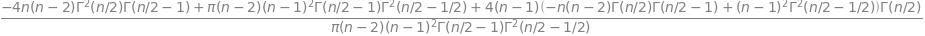

In [67]:
n = sympy.Symbol("n")

expr = sympy.together(1 - n * (c(n-2)/s(n-2))**2 + n * (n-1) * (c(n - 1) * c(n - 3) / (s(n-2) * s(n-3)) - (c(n - 2) / s(n-2))**2))

expr


In [68]:
float(expr.subs(n, 1000.0)) - float((1 - 3/pi))


In [69]:
float(expr.subs(n, 10000000.0)) - float((1 - 3/pi))


## Application

Barry Rowlingson and John Mount asked the following question ([ref](https://github.com/WinVector/Examples/blob/main/L1L2/exp_l2.md)).

> For a positive integer $n$, take $v_1$, $v_2$ vectors in $\mathbb{R}^n$ with each coordinate generated IID normal mean zero, standard deviation 1. Let $p_n$ denote the probability that $(||v_1||_1 \ge ||v_2||_1) = (||v_1||_2 \ge ||v_2||_2)$ $p_n$.  What is $\lim_{n \rightarrow \infty} p_n$?

Interestingly $p_n$, which is essentially the AUC of matching the L1 norm to the L2 norm, seems to converge to a constant strictly in the region $(1/2, 1)$ (empirically, approximately $0.885$). Let's call this quantity the "L1L2 AUC", and work out what it is.

We can prove this with the following observations.

  1) From the Wikipedia [Chi-squared_distribution](https://en.wikipedia.org/wiki/Chi-squared_distribution) page:
     > If $X \sim \Chi(k)$ then $\sqrt{2 X}$ is approximately normally distributed with mean $\sqrt{2k−1}$ and unit variance (1922, by R. A. Fisher, see (18.23), p. 426 of Johnson).
  2) From earlier in this note, the variance in the L1 measure of a vector with L2 measure 1 is about $1 - 3/\pi$.

The point is: both of those distributions have nearly constant variances bounded away from zero! If we further assume that both distributions are well approximated by a normal as $n \rightarrow \infty$, then we could argue the following.

Let $R_1$ and $R_2$ be the random variables representing the L2-radii of $v_1$ and $v_2$. Let $S_1$ and $S_2$ be the random variables that are the value of the sum of the absolute values of $v_1 / ||v_1||_2$ and $v_2 / ||v_2||_2$. Then our "AUC of the L2 versus L1 metrics" problem is how often $(R_1 \ge R_2) = (R_1 S_1 \ge R_2 S_2)$.

By above $R_1$ and $R_2$ are approximately normally distributed with mean $\sqrt{n - 1/2}$ and variance $1/2$. We know $S_1$ and $S_2$ have mean $a_{n} \approx \sqrt{2 n / \pi}$ and variance $v_{n} \approx 1 - 3 / \pi$. Treat them as being approximately normal (something we have not established).

To show $\lim_{n \rightarrow \infty} p_{n} \in (1/2, 1)$ it should suffice to show  $\text{P}[(R_1 \ge R_2) = (R_1 S_1 \ge R_2 S_1)] = z$ for some $z \in (1/2, 1)$. 

Define new random variables:

  * $U_{i} := R_{i} / \sqrt{n} - \sqrt{1 - 1/(2 n)}$ (mean $0$, variance $1 / (2 n)$, approaching normal)
  * $V_{i} := S_{i} / \sqrt{n} - \sqrt{2 / \pi}$ (mean $0$, variance $(1 - 3 / \pi) / n$, assumed approaching normal).

We have:

  * $(R_{1} \ge R_{2}) = ((U_{1} + \sqrt{1 - 1/(2 n)}) \ge (U_{2} + \sqrt{1 - 1/(2 n)}))$ 
  * $(R_1 S_1 \ge R_2 S_1) = ((U_1 + \sqrt{1 - 1/(2 n)}) (V_1 + \sqrt{2 / \pi}) \ge (U_2 + \sqrt{1 - 1/(2 n)}) (V_1 + \sqrt{2 / \pi}))$. 
  
We will exploit that as $n$ gets large we have with high probability $(U_{i} + \sqrt{1 - 1/(2 n)}) (V_{i} + \sqrt{2 / \pi}) \asymp (U_{i} + 1) (V_{i} + \sqrt{2 / \pi}) \asymp \sqrt{2 / \pi} U_{i} + V_{i} + \sqrt{2 / \pi}$ (i.e. we can often drop the term $U_{i} V_{i}$, when it is $\propto 1/n^2$). Therefore we want the rate that the following two terms agree:

  * $\sqrt{2 / \pi} U_{1} - \sqrt{2 / \pi} U_{2} \ge 0$ 
  * $\sqrt{2 / \pi} U_{1} - \sqrt{2 / \pi} U_{2} + V_{1} - V_{2} \ge 0$

Define $\kappa(\sigma_1, \sigma_2)$ as $\text{P}[(X + Y \ge 0) = (X \ge 0)]$ where $X$ is normal mean $0$ variance $\sigma_1^2$ and $Y$ is independent normal mean $0$ variance $\sigma_2^2$. A cool fact we will use: $\kappa(\sigma_1, \sigma_2) = \kappa(s \sigma_1, s \sigma_2)$ for $s > 0$.

Then our answer is:

$$
\begin{align*}
\kappa(2 \sqrt{2 / \pi} \sqrt{1 / (2 n)}, 2 \sqrt{(1 - 3 / \pi) / n}) 
  &= \kappa(\sqrt{1 / \pi}, \sqrt{1 - 3 / \pi}) \\
  &= \kappa(1, \sqrt{\pi - 3}) \\
  &\approx 0.885
\end{align*}
$$

Some notes on $\kappa(,)$ can be found [here](https://github.com/WinVector/Examples/blob/main/L1L2/kappa.ipynb).


## Conclusion

Let $a_{n}$ be the expected value of $\sum_{i=1}^{n} |x_i|$ given $\sum_{i=1}^{n} x_i^2 = 1$ where $x$ is uniformly distributed such, and $v_{n}$ as the variance of this same sum.

We have shown for large $n$: $a_n \approx \sqrt{2 n/ \pi}$. Or, in high dimensions the typical L2 norm-1 vector has an expected L1 norm of about $\sqrt{2 n / \pi}$. The variance $v_n \approx 1 - 3 / \pi$ (a constant independent of dimension!).

We used the above to show that the "L1L2 AUC" (or concordance/agreement) is about $0.885$ for the standard $n$-dimensiojnal normal, as dimension gets large.

I think it is pretty neat the large scale behavior limits to constants in high dimension, and is characterizable.
